In [1]:
import time
import spacy
import random
import pandas as pd
from tqdm import tqdm
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt
from langchain.schema import HumanMessage
from langchain.chat_models import AzureChatOpenAI
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

/home/os-andrew.ja.tsai/Desktop/venv/legal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import shutil
# import matplotlib
# shutil.rmtree(matplotlib.get_cachedir())

In [4]:
df = pd.read_csv('../data/processed_all_crimes_5000.csv')

df.head()

,JID,JYEAR,JCASE,JNO,JDATE,JTITLE,JFULL,length,main_body,penalties,defendants,enforced_acts,sentences,digit_sentences,behaviors
0,"TPCM,87,台覆,7-1,20000127",87,台覆,7-1,1970-01-01 00:00:00.020000127,叛亂罪,司法院冤獄賠償覆議委員會決定書 八十七年度台覆字第七－一號\r\n 聲請再...,1246,理由按*******************************************...,聲請駁回。,[],['冤獄賠償法第4條'],NaN,NaN,聲請駁回。
1,"TPCM,89,台覆,1,20000127",89,台覆,1,1970-01-01 00:00:00.020000127,擄人勒贖罪,司法院冤獄賠償覆議委員會決定書 八十九年度台覆字第一號\r\n 聲請覆...,1759,理由本件聲請意旨略以：甲○○因擄人勒贖、傷害、恐嚇危害安全等罪一案，於民國（下同）八十五年...,原決定撤銷。甲○○於無罪判決確定前受覊押壹佰貳拾貳日，准予賠償新台幣肆拾捌萬捌仟元。,[],"['冤獄賠償法第3條', '冤獄賠償法第13條', '冤獄賠償法第1條']",NaN,NaN,原決定撤銷。甲○○於無罪判決確定前受覊押壹佰貳拾貳日，
2,"TPCM,89,台覆,10,20000127",89,台覆,10,1970-01-01 00:00:00.020000127,殺人,司法院冤獄賠償覆議委員會決定書 八十九年度台覆字第一○號\r\n 聲請覆...,1719,理由按「受無罪之宣告，曾受覊押，其行為違反公共秩序者，不得請求賠償。」***********...,原決定應予維持。,[],['冤獄賠償法第2條'],NaN,NaN,原決定應予維持。
3,"TPCM,89,台覆,11,20000127",89,台覆,11,1970-01-01 00:00:00.020000127,違法覊押,司法院冤獄賠償覆議委員會決定書 八十九年度台覆字第一一號\r\n 聲請覆...,1451,理由本件聲請賠償意旨略以：聲請人於七十八年一月至六月，經高雄縣鳳山分局成功派出所主管王國基逮...,原決定應予維持。,[],['冤獄賠償法第1條'],NaN,NaN,原決定應予維持。
4,"TPCM,89,台覆,12,20000127",89,台覆,12,1970-01-01 00:00:00.020000127,槍砲彈藥刀械管制條例,司法院冤獄賠償覆議委員會決定書 八十九年度台覆字第一二號\r\n 聲請覆...,1710,理由本件聲請覆議人甲○○因違反*******************************...,原決定撤銷。甲○○於不起訴處分確定前，受覊押拾柒日，准予賠償新台幣陸萬捌仟元。,[],"['冤獄賠償法第3條', '冤獄賠償法第13條']",NaN,NaN,原決定撤銷。甲○○於不起訴處分確定前，受覊押拾柒日，


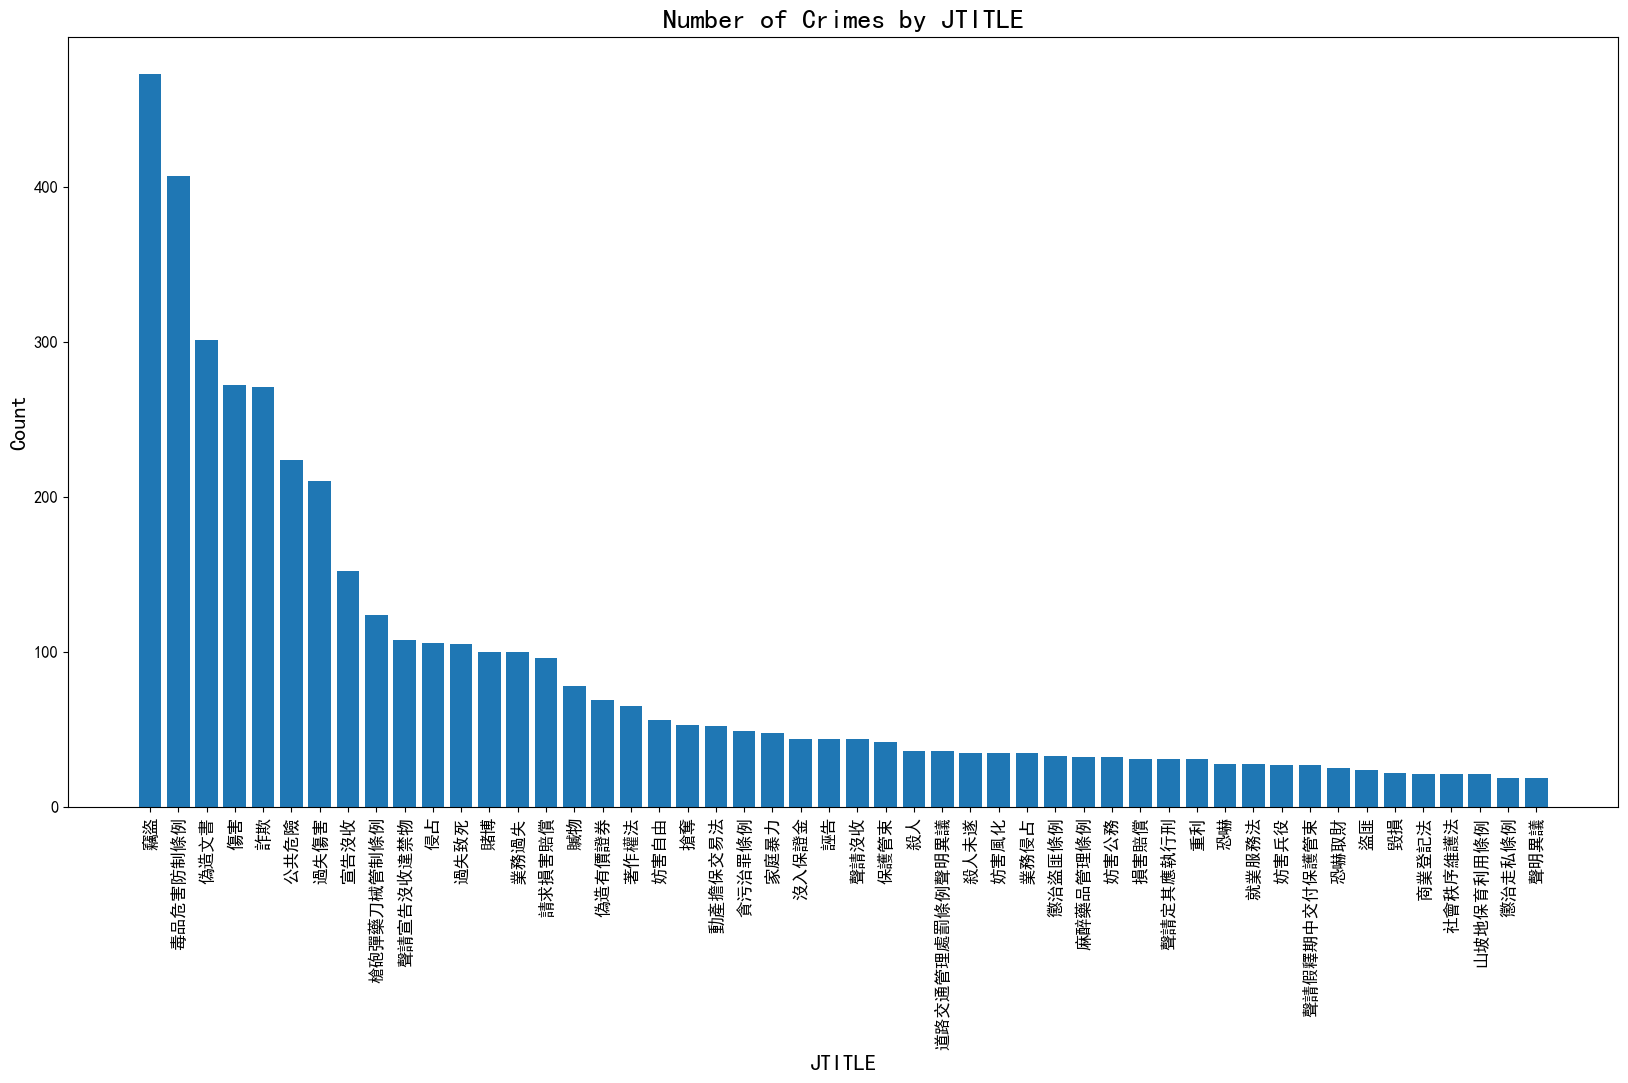

In [ ]:
# Count the number of each JTITLE type
jt_counts = df['JTITLE'].value_counts()[:50]

# Plot the counts
plt.figure(figsize=(20,10))
plt.bar(jt_counts.index, jt_counts.values)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('JTITLE', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Number of Crimes by JTITLE', fontsize=20)
plt.show()


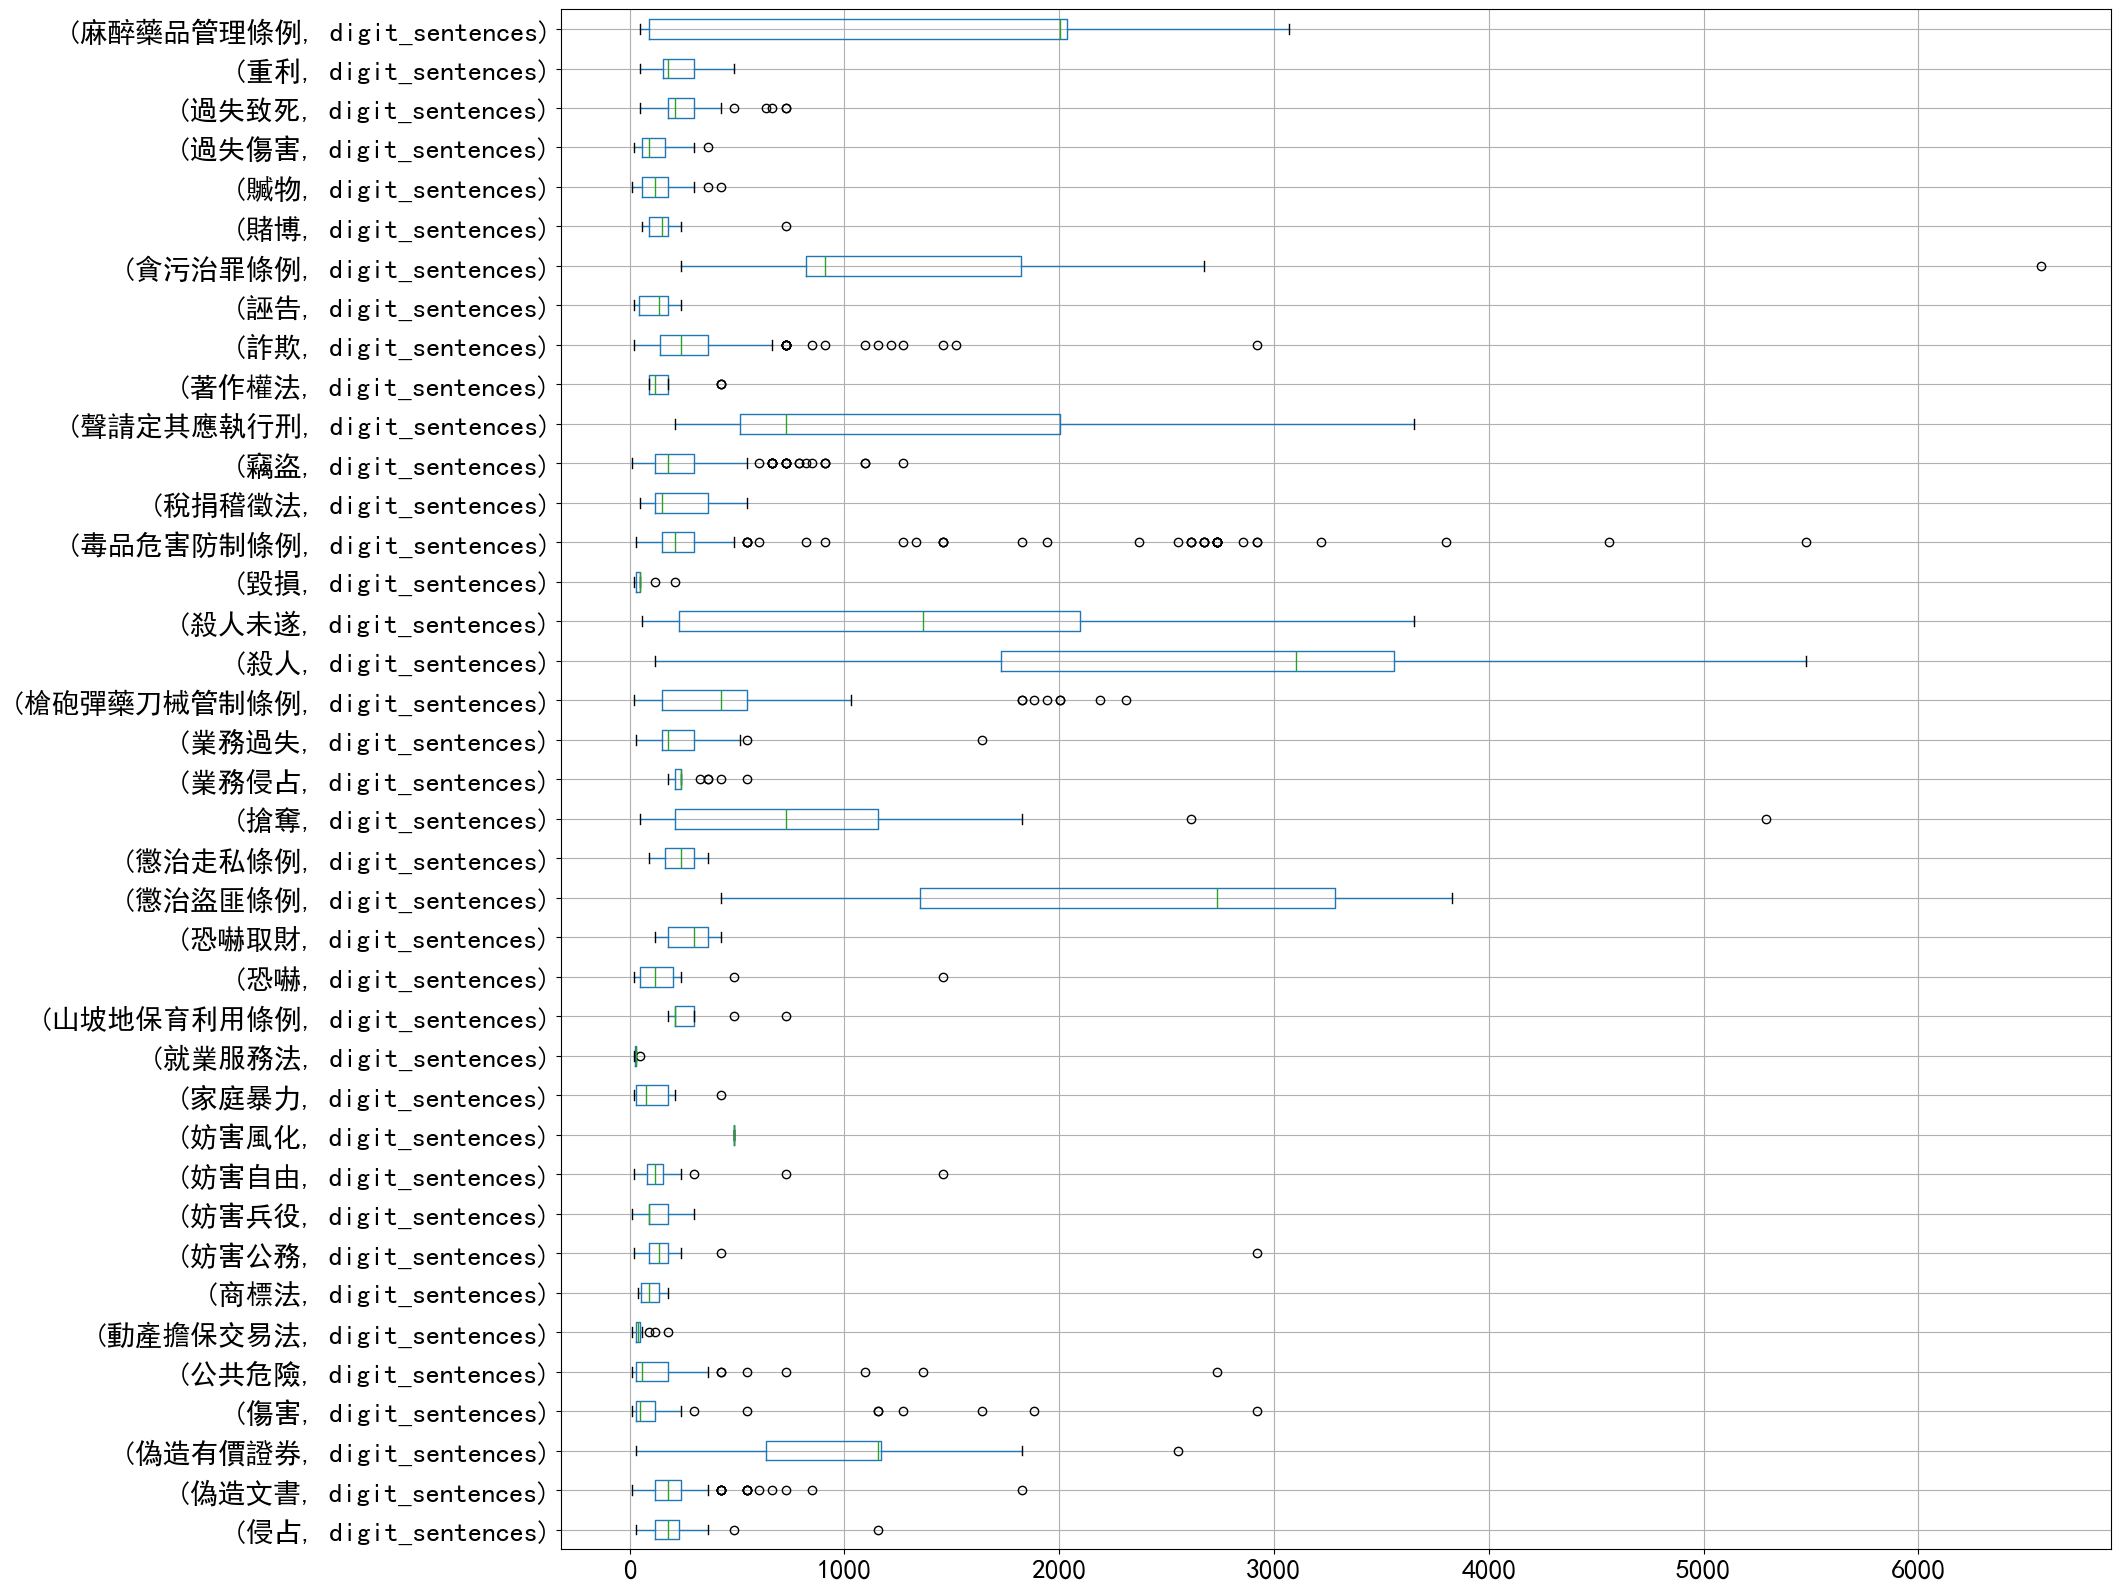

In [ ]:
top_JTITLEs = df[df.main_body.notna()].JTITLE.value_counts()[:50].index
df_t = df[df.digit_sentences.notna()]
df_t = df_t[df_t.JTITLE.isin(top_JTITLEs)]
df_t = df_t[['JTITLE','digit_sentences']]
df_t.groupby(df_t.JTITLE).boxplot(subplots=False,fontsize=20,figsize=(20,20),vert=False)
plt.show()

In [5]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("bert-base-chinese")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=20, n_components=5, min_dist=0.0, metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()
# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

No sentence-transformers model found with name /home/os-andrew.ja.tsai/.cache/torch/sentence_transformers/bert-base-chinese. Creating a new one with MEAN pooling.


In [10]:
# all_sentences = df[df.behaviors.notna()].behaviors
all_sentences = [para for doc in df[df.main_body.notna()].main_body 
                 for para in doc.split('。') if para]
all_sentences[:10]

['理由按*********************************************************************************************************************',
 '本件聲請再覆議人以其因叛亂罪經前台灣省保安司令部自民國（下同）三十九年五月十四日起羈押，嗣經判處有期徒刑五年確定，至四十四年五月十三日執行期滿後，竟逾期羈押至四十四年八月三日，遭違法羈押三個月，依法聲請國家賠償一案，對台灣桃園地方法院八十六年度賠字第三號及本會前開決定駁回其聲請，爰依司法院大法官釋字第四七七號解釋聲明不服',
 '依首揭說明，本會該決定即屬最後之決定，不得聲請再覆議，乃聲請再覆議人竟對本會之決定聲請再覆議，難認為合法，應予駁回',
 '倘另發生原決定意旨以外聲請國家賠償之法定事由，自應另案向管轄法院提出聲請',
 '理由\uf6b0本件聲請意旨略以：甲○○因擄人勒贖、傷害、恐嚇危害安全等罪一案，於民國（下同）八十五年三月十四日經台灣桃園地方法院檢察署執行覊押，至同年七月十三日經台灣桃園地方法院責付開釋，共受覊押一百二十二日，嗣經台灣高等法院判決無罪確定在案，爰依法請求冤獄賠償等情',
 '\uf6af原決定意旨略以：甲○○固經覊押，且其覊押案由中恐嚇危害安全部分經判決無罪確定屬實，但其中傷害部分係經告訴人黃清琳撤回告訴而為不受理判決，顯非全部均受無罪判決確定，其據以請求冤獄賠償，於法不合，應予駁回',
 '\uf6ae聲請覆議意旨略以：原決定徒以覊押案由中之傷害部分非受無罪判決為由，遽予駁回其聲請冤獄賠償，尚有疏誤，請求按每日新台幣（下同）五千元之標準准予賠償',
 '\uf6ad經查，甲○○係因擄人勒贖等罪一案，於八十五年三月十四日經台灣桃園地方法院檢察署覊押，至同年七月十三日經台灣桃園地方法院責付停止覊押，共受覊押一百二十二日',
 '其受覊押案由中擄人勒贖部分，經台灣桃園地方法院檢察署檢察官於同年七月九日以八十五年度偵字第三五六二號為不起訴處分確定，提起公訴之傷害及恐嚇危害安全兩部分，則經台灣桃園地方法院於八十六年三月二十五日以八十五年度重訴字第三十三號分別諭知公訴不受理（因告訴人撤回告訴）、無罪，繼經台灣高等法院於八十六年九月十五日以八十六年度上重訴字第五十一號就恐嚇危害安全部分之上訴，予以駁

In [11]:
topic_model.fit(all_sentences[:10000])

In [12]:
topic_model.visualize_hierarchy()

In [14]:
for i in range(-1,len(topic_model.get_topic_info())-1):
    print(i)
    for doc in topic_model.get_representative_docs(i):
        print(doc)

-1
從形式上觀察，並無違背法令之情形存在
上訴意旨，仍執陳詞爭辯，並對原審採證認事職權之適法行使，任意指摘，非有理由，應予駁回
」等語
0
據上論結，應依********************
據上論結，應依********************
據上論結，應依********************
1
本件告訴人吳建雄就其被害事實所為之指述，前後不盡相同，即使在原審調查時，其仍語帶含糊，忽謂：「忘記了（指上訴人當天曾否在場）」，緊接者即改稱：「我有看到他（指上訴人）沒錯，但人太多，我忘記他做什麼」，其後又稱：「到療養院後方山區及至宜蘭時他（指上訴人）都有在」，但法官詢以：「去你家他有無在場﹖」時，隨即改稱：「到宜蘭時，我可能睡覺了，不知道」（見原審卷第一○四頁正、背面、第一○五頁），原審採納吳建雄在其調查及警訊、偵查與第一審法院審理時之供述，作為認定上訴人犯罪之證據資料，惟就吳建雄前後不一之指述，採取何部分、捨棄何部分，何以採取、憑何捨棄，俱未依據其調查證據之結果，詳予說明，殊嫌理由不備，且不足以昭折服
㈡上訴人等始終否認容留溫○○妹與男客姦淫牟利，僅供承僱用溫○○妹從事按摩工作，原判決認定上訴人等意圖營利容留溫○○妹與男客姦淫，係以溫○○妹及男客江○榮之警訊供述為論據，然溫○○妹於警訊中係證稱：每一節收費一千元，全身按摩包括猥褻行為至射精，如客人要求性交再多收一千元……與店方五五分帳，性交部分一千元我獨得等語(見偵查卷第六頁背面)，所言「如客人要求性交」再多收一千元，是否能認為其已與男客有過性交易？而男客江○榮業於警訊中陳明：已答應從事性交易，但適逢警察臨檢，所以尚未進行性交易（見偵查卷第八頁背面），原判決亦認定八十五年十一月二十四日警方查獲當天，溫○○妹與江○榮僅做色情按摩，另在現場所查扣已使用過之保險套一個，原判決又認為與本案無何關聯(見原判決第三頁正面第六、七行)，則上訴人等有無圖利容留溫○○妹與人姦淫並恃以為業之情形，即有待調查釐清，此部分原審未予究明，併有調查未盡及判決理由不備之可議
查獲之槍、彈是否係與上訴人在室內聊天，警察進入屋內時，趁隙溜走之綽號「阿炮」者所持有，抑或另有其他之第三人所放置﹖原判決就此，亦在理由內說明：「被告對於該所謂『阿炮』者之年籍姓名均不清楚，而被告在警員入內搜索前，既與綽號『阿炮』者共處一室，對於『阿炮』之擧止當非常

In [15]:
topic_model.visualize_topics()

### A case showing that simply asking ChatGPT to generate crime elements is not enough given that it doesn't have the context of the crime type

In [16]:
# Load OpenAI model from Azure Cloud

BASE_URL = 'https://scusmsadrcdasopenaijapan.openai.azure.com/'
DEPLOYMENT_NAME = "gpt-35-turbo"
API_TYPE = 'azure'
API_KEY = 'ＸＸＸ'
API_VERSION = "2023-05-15"
MODEL_VERSION = 2

model = AzureChatOpenAI(
    openai_api_base=BASE_URL,
    openai_api_version=API_VERSION,
    deployment_name=DEPLOYMENT_NAME,
    openai_api_key=API_KEY,
    openai_api_type=API_TYPE,
    model_version=MODEL_VERSION
)

In [17]:
prompt = """
找出下列文章的案件情節並條列出來:
{}
案件情節如下：
"""
id = 55
response = model([HumanMessage(content=prompt.format(df.main_body[id][:2000]))])
response.content.split('\n')

['- 上訴人甲○○基於非法販賣安非他命營利之意圖，先後於八十五年十月上旬及同年十二月上旬，在高雄市○○路向蔡文乾販入安非他命二兩及三兩，再於八十五年十二月十九日上午十時三十分許，在台中縣太平市○○路之郵局，非法販賣安非他命一兩予李文華，圖得利益五千元。',
 '- 上訴人於同日晚間十一時十分許攜帶安非他命一大包前往李文華住處，擬再非法販賣予李文華時，當場被警方查獲。',
 '- 警方復轉往上訴人住處，查扣上訴人所有之安非他命一大包，合計共查扣安非他命二大包（驗餘淨重六八‧七七公克）等情。',
 '- 撤銷第一審關於非法販賣安非他命部分之判決，改判仍論處上訴人連續非法販賣化學合成麻醉藥品，累犯罪刑。',
 '- 上訴人辯稱與李文華交換海洛因施用，而非販賣安非他命，但李文華否認有交換海洛因情事。',
 '- 上訴人辯稱其先後共販入安非他命五兩，其中一兩販賣予李文華，餘二兩被警方查扣。證據顯示上訴人自承非法吸用安非他命，且其所述販入安非他命之數量與查獲之數量不符。',
 '- 檢察官移送併案審理中，上訴人被指控於八十六年四月二日非法販賣安非他命予綽號「阿坤」，但上訴人堅稱自己當天在桃園縣工作，並有打卡紀錄影本作為證據。證人彭金陵亦證稱上訴人當天在該公司上班。無其他證據能證明上訴人有此部分犯行。']